Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 754  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 542          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0003002323 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | -2.37e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.72e+06     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000483    |
|    val

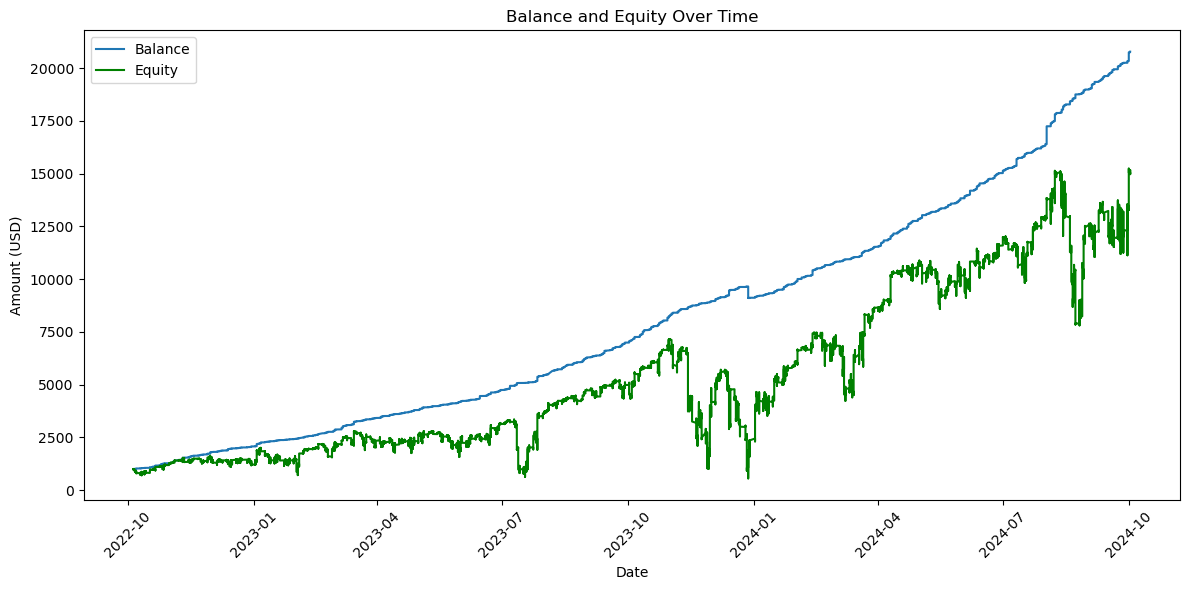

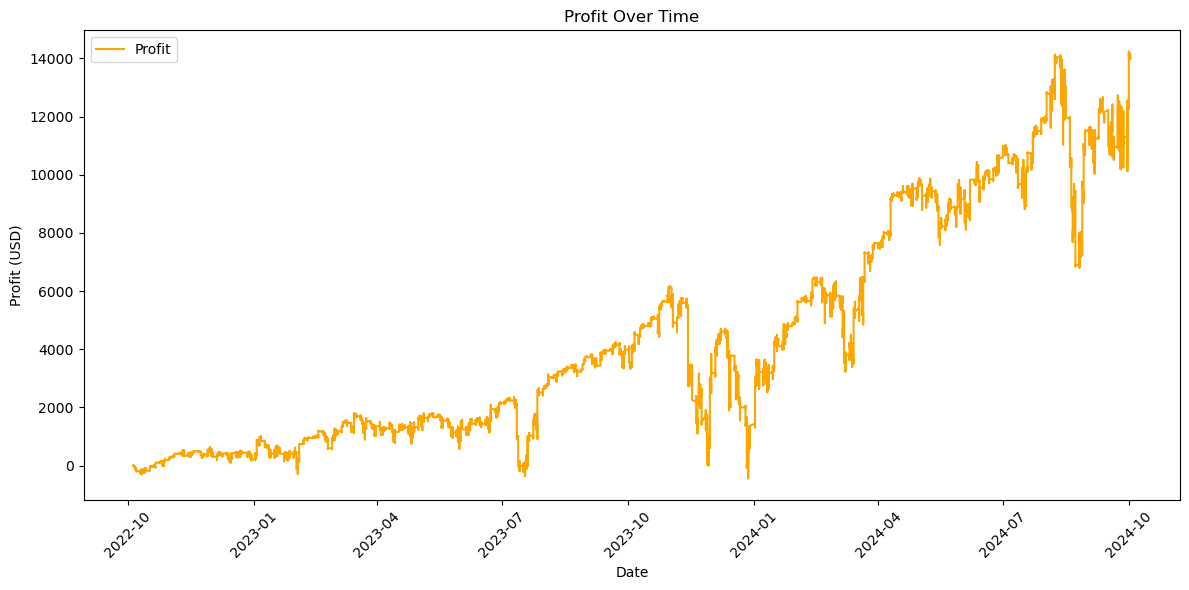

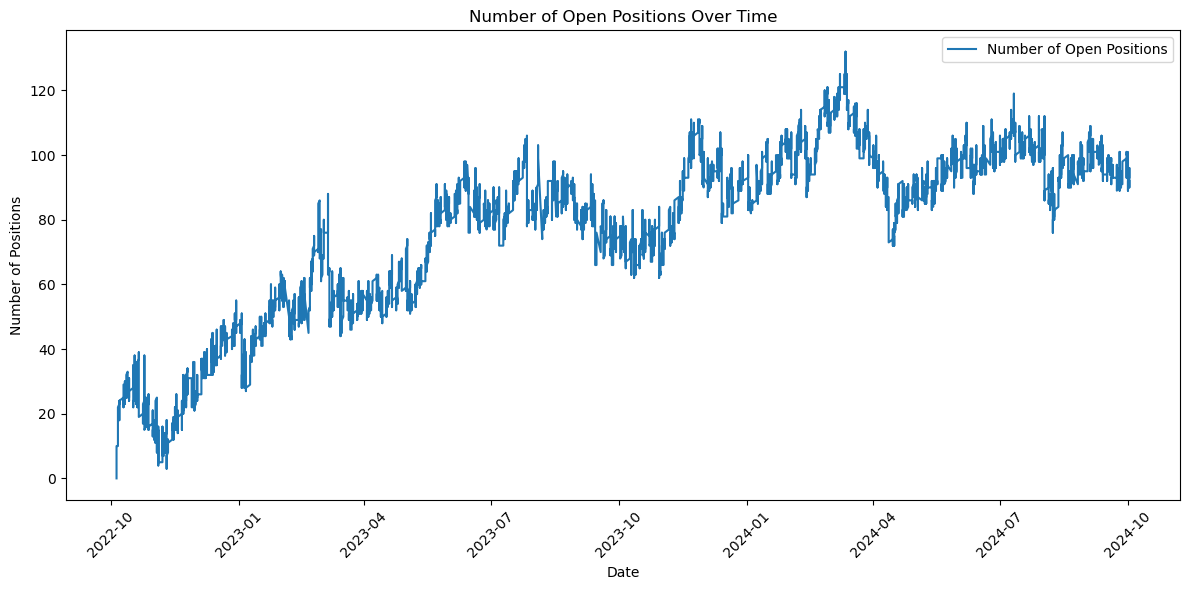

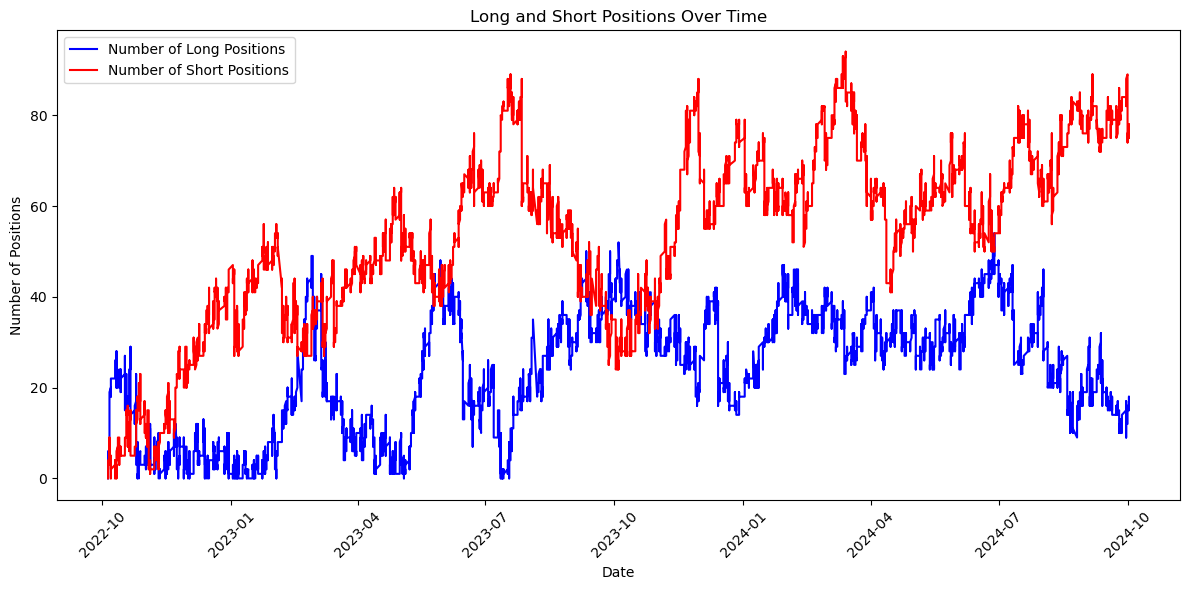

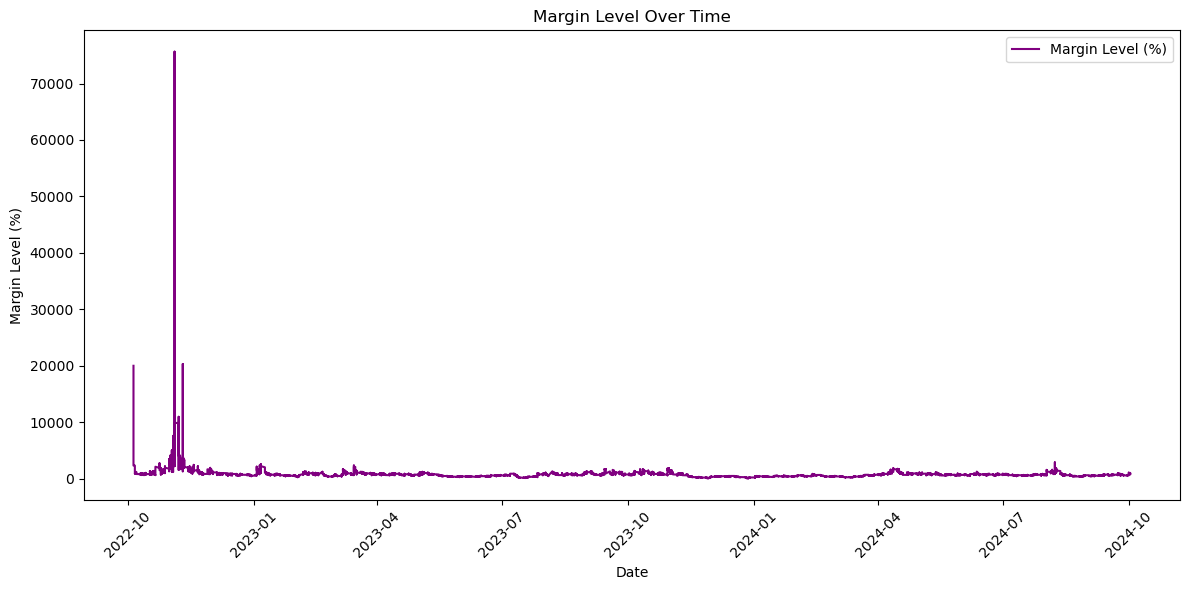

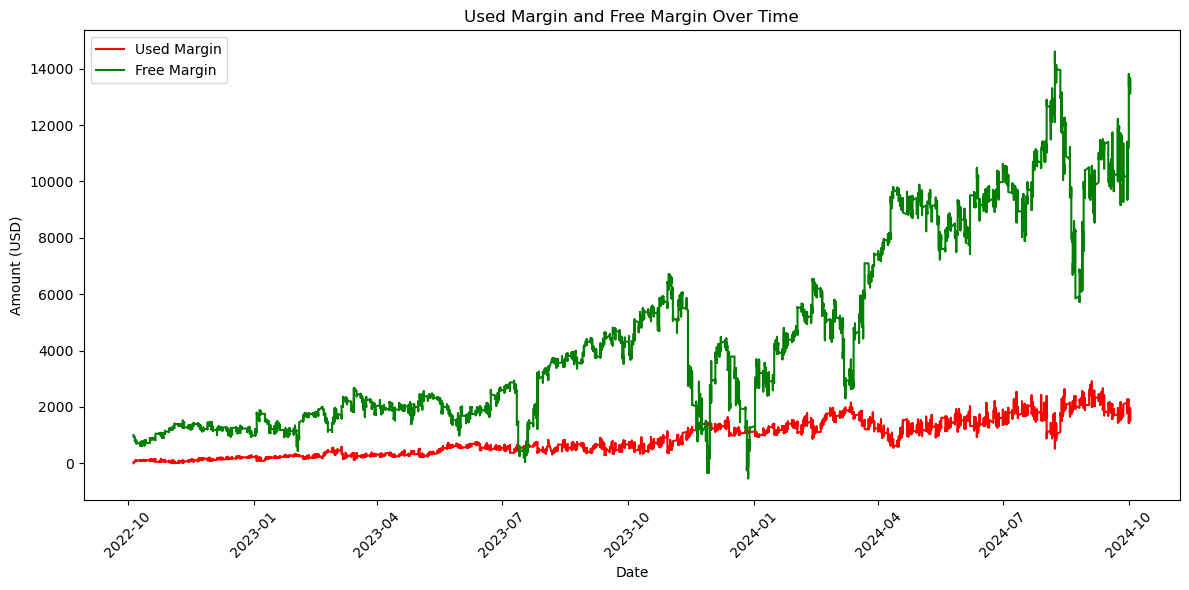

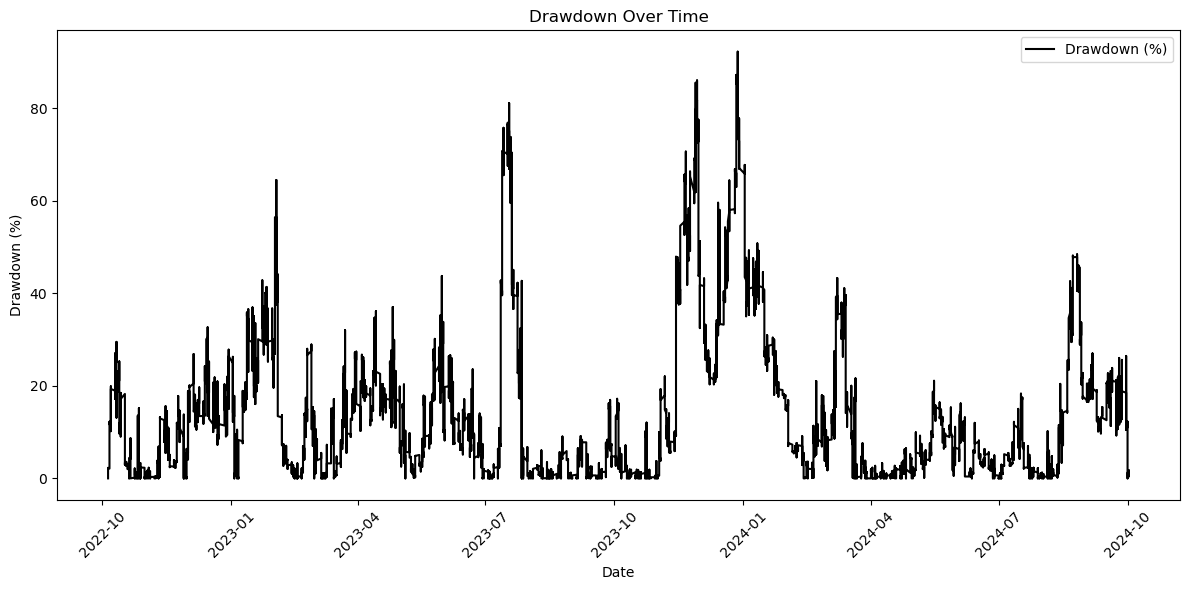

In [17]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================

# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\RL_Forex_Trading_EA\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos', 'DateTime'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================

# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================

# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# ================================
# 5. SCALING AND NORMALIZING FEATURES
# ================================

# Before scaling, save unscaled prices for profit calculations
df['Unscaled_Open'] = df['Open']
df['Unscaled_High'] = df['High']
df['Unscaled_Low'] = df['Low']
df['Unscaled_Close'] = df['Close']

# Exclude price columns from scaling
price_columns = ['Open', 'High', 'Low', 'Close', 'Unscaled_Open', 'Unscaled_High', 'Unscaled_Low', 'Unscaled_Close']

# Select numerical columns to scale (excluding price columns)
numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() if col not in price_columns]

# Initialize scaler
scaler = MinMaxScaler()

# Fit scaler on the data and transform
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# ================================
# 6. DEFINING THE CUSTOM TRADING ENVIRONMENT
# ====================================

class ForexTradingEnv(gym.Env):
    """
    A custom OpenAI Gym environment for Forex trading that allows multiple positions and enforces specific closing rules,
    with margin and leverage considerations.
    """
    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()

        self.long_positions_history = []
        self.short_positions_history = []

        self.df = df.reset_index(drop=True)  # Ensure the DataFrame index is sequential
        self.total_steps = len(self.df)

        # Initial account balance (Cent Account with $1,000 USD)
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.equity = self.initial_balance

        # Leverage and margin settings
        self.leverage = 200  # Leverage ratio
        self.margin_call_level = 100  # Margin Call Level (%)
        self.stop_out_level = 50  # Stop Out Level (%)

        # Margin variables
        self.used_margin = 0
        self.free_margin = self.balance - self.used_margin
        self.margin_level = np.inf  # Initially infinite when no positions are open

        # Positions will be stored in a list
        self.open_positions = []  # Each position is a dictionary with 'type', 'entry_price', and 'size'

        # For tracking history
        self.balance_history = []
        self.equity_history = []
        self.position_history = []
        self.used_margin_history = []
        self.free_margin_history = []
        self.margin_level_history = []

        # Exclude unscaled price columns from observation
        price_columns = ['Unscaled_Open', 'Unscaled_High', 'Unscaled_Low', 'Unscaled_Close']
        self.numeric_columns = [col for col in self.df.select_dtypes(include=[np.number]).columns.tolist() if col not in price_columns]

        # Define action and observation space
        # Action space: 0 - Hold, 1 - Buy/Open Long, 2 - Sell/Open Short, 3 - Attempt to Close Positions
        self.action_space = spaces.Discrete(4)

        # Observation space: all numerical features except unscaled prices, plus margin variables
        num_features = len(self.numeric_columns) + 3  # Additional margin variables
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        """
        Reset the state of the environment to an initial state.
        """
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.equity = self.initial_balance
        self.open_positions = []

        # Reset margin variables
        self.used_margin = 0
        self.free_margin = self.balance - self.used_margin
        self.margin_level = np.inf

        # Reset history
        self.balance_history = [self.balance]
        self.equity_history = [self.equity]
        self.position_history = [len(self.open_positions)]
        self.used_margin_history = [self.used_margin]
        self.free_margin_history = [self.free_margin]
        self.margin_level_history = [self.margin_level]

        # Initialize long and short positions history
        num_long_positions = sum(1 for pos in self.open_positions if pos['type'] == 'long')
        num_short_positions = sum(1 for pos in self.open_positions if pos['type'] == 'short')

        self.long_positions_history = [num_long_positions]
        self.short_positions_history = [num_short_positions]

        return self._next_observation(), {}

    def _next_observation(self):
        """
        Get the observation for the current step.
        """
        # Extract the current row
        obs = self.df.loc[self.current_step, self.numeric_columns].values.astype(np.float32)

        # Replace any NaNs with zeros to ensure stability
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)

        # Add margin variables to observation
        # Handle infinite margin_level by capping it to a large finite value
        capped_margin_level = self.margin_level if np.isfinite(self.margin_level) else 1e6
        additional_obs = np.array([
            self.used_margin / self.initial_balance,
            self.free_margin / self.initial_balance,
            capped_margin_level / 1000  # To normalize
        ], dtype=np.float32)

        # Ensure no NaNs or Infs in additional_obs
        additional_obs = np.nan_to_num(additional_obs, nan=0.0, posinf=1e6 / 1000, neginf=0.0)

        # Concatenate the margin information to the observation
        obs = np.concatenate((obs, additional_obs))

        # Final check for NaNs in the observation
        if np.any(np.isnan(obs)):
            print(f"NaN detected in observation at step {self.current_step}")
            obs = np.nan_to_num(obs, nan=0.0, posinf=1e6 / 1000, neginf=0.0)

        return obs

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        terminated = False
        truncated = False

        # Use unscaled close price for profit calculations
        current_price = self.df.loc[self.current_step, 'Unscaled_Close']
        total_realized_profit = 0

        # Initialize penalty for invalid actions
        penalty = 0

        # Execute action
        if action == 1:
            # Open Long Position
            if len(self.open_positions) < 400:  # Limit the number of open positions to 400
                risk_percentage = 1
                self.position_size = self.equity * risk_percentage
                required_margin = self.position_size / self.leverage
                if self.free_margin >= required_margin:
                    position = {
                        'type': 'long',
                        'entry_price': current_price,
                        'size': self.position_size
                    }
                    # Proceed to open position
                    self.open_positions.append(position)
                    # Update margins
                    self.used_margin += required_margin
                    self.free_margin -= required_margin
                else:
                    # Not enough free margin to open position
                    penalty -= 10  # Penalize the agent for invalid action
            else:
                # Too many open positions
                penalty -= 10  # Penalize the agent for invalid action

        elif action == 2:
            # Open Short Position
            if len(self.open_positions) < 400:  # Limit the number of open positions to 400
                risk_percentage = 1
                self.position_size = self.equity * risk_percentage
                required_margin = self.position_size / self.leverage
                if self.free_margin >= required_margin:
                    position = {
                        'type': 'short',
                        'entry_price': current_price,
                        'size': self.position_size
                    }
                    # Proceed to open position
                    self.open_positions.append(position)
                    # Update margins
                    self.used_margin += required_margin
                    self.free_margin -= required_margin
                else:
                    # Not enough free margin to open position
                    penalty -= 10  # Penalize the agent for invalid action
            else:
                # Too many open positions
                penalty -= 10  # Penalize the agent for invalid action

        elif action == 3:
            # Attempt to Close Positions
            profit_positions = []
            loss_positions = []
            positions_to_close = []

            # Separate positions into profitable and losing
            for pos in self.open_positions:
                if pos['type'] == 'long':
                    pnl = (current_price - pos['entry_price']) * pos['size']
                else:  # 'short'
                    pnl = (pos['entry_price'] - current_price) * pos['size']

                if pnl > 0:
                    profit_positions.append({'position': pos, 'pnl': pnl})
                else:
                    loss_positions.append({'position': pos, 'pnl': pnl})

            # Total profit from profitable positions
            profit_from_profitable_positions = sum([p['pnl'] for p in profit_positions])

            if profit_from_profitable_positions > 0:
                # Close profitable positions
                for p in profit_positions:
                    # Update balance
                    self.balance += p['pnl'] * 0.5  # Half of profit goes to balance
                    total_realized_profit += p['pnl']
                    # Release margin
                    required_margin = p['position']['size'] / self.leverage
                    self.used_margin -= required_margin
                    self.free_margin += required_margin
                    positions_to_close.append(p['position'])

                # Use half of profit to close losses
                available_for_losses = profit_from_profitable_positions * 0.5

                # Sort loss positions by PnL ascending (smallest losses first)
                loss_positions.sort(key=lambda x: x['pnl'])

                for l in loss_positions:
                    required_amount = -l['pnl']
                    if available_for_losses >= required_amount:
                        # Can fully close this losing position
                        total_realized_profit += l['pnl']  # Negative value
                        # Release margin
                        required_margin = l['position']['size'] / self.leverage
                        self.used_margin -= required_margin
                        self.free_margin += required_margin
                        positions_to_close.append(l['position'])
                        available_for_losses -= required_amount
                    else:
                        # Partially close the losing position
                        partial_size = (available_for_losses / required_amount) * l['position']['size']
                        partial_pnl = l['pnl'] * (partial_size / l['position']['size'])
                        # Adjust the position size accordingly
                        l['position']['size'] -= partial_size
                        total_realized_profit += partial_pnl  # Negative value
                        # Release margin for the partial size
                        required_margin = partial_size / self.leverage
                        self.used_margin -= required_margin
                        self.free_margin += required_margin
                        available_for_losses = 0
                        break  # No more funds to close additional losses

                # Remove closed positions from open_positions
                for pos in positions_to_close:
                    if pos in self.open_positions:
                        self.open_positions.remove(pos)

        # Calculate unrealized PnL
        unrealized_pnl = 0
        for pos in self.open_positions:
            if pos['type'] == 'long':
                pnl = (current_price - pos['entry_price']) * pos['size']
            else:  # 'short'
                pnl = (pos['entry_price'] - current_price) * pos['size']
            unrealized_pnl += pnl

        # Update equity
        self.equity = self.balance + unrealized_pnl

        # Update free margin
        self.free_margin = self.equity - self.used_margin

        # Update margin level, ensuring no division by zero
        if self.used_margin > 0:
            self.margin_level = (self.equity / self.used_margin) * 100
        else:
            self.margin_level = 1e6  # Assign a large finite value instead of infinity

        # Check for margin call / stop out
        if self.margin_level <= self.stop_out_level:
            # Close positions until margin level is above stop out level
            positions_to_close = []
            # Sort positions by PnL ascending (largest losses first)
            positions_with_pnl = []
            for pos in self.open_positions:
                if pos['type'] == 'long':
                    pnl = (current_price - pos['entry_price']) * pos['size']
                else:  # 'short'
                    pnl = (pos['entry_price'] - current_price) * pos['size']
                positions_with_pnl.append({'position': pos, 'pnl': pnl})

            positions_with_pnl.sort(key=lambda x: x['pnl'])

            for p in positions_with_pnl:
                # Close position
                if p['pnl'] >= 0:
                    self.balance += p['pnl']
                else:
                    self.balance += p['pnl']  # Negative value
                total_realized_profit += p['pnl']

                # Release margin
                required_margin = p['position']['size'] / self.leverage
                self.used_margin -= required_margin
                self.free_margin += required_margin

                positions_to_close.append(p['position'])

                # Recalculate equity and margin level
                unrealized_pnl -= p['pnl']  # Subtract the PnL of the closed position
                self.equity = self.balance + unrealized_pnl

                if self.used_margin > 0:
                    self.margin_level = (self.equity / self.used_margin) * 100
                else:
                    self.margin_level = 1e6  # Assign a large finite value instead of infinity

                if self.margin_level > self.stop_out_level:
                    break  # Margin level is acceptable

            # Remove closed positions from open_positions
            for pos in positions_to_close:
                if pos in self.open_positions:
                    self.open_positions.remove(pos)

        # Append history
        self.balance_history.append(self.balance)
        self.equity_history.append(self.equity)
        self.position_history.append(len(self.open_positions))
        self.used_margin_history.append(self.used_margin)
        self.free_margin_history.append(self.free_margin)
        self.margin_level_history.append(self.margin_level)

        num_long_positions = sum(1 for pos in self.open_positions if pos['type'] == 'long')
        num_short_positions = sum(1 for pos in self.open_positions if pos['type'] == 'short')

        self.long_positions_history.append(num_long_positions)
        self.short_positions_history.append(num_short_positions)

        # Move to the next step
        self.current_step += 1

        # Check if the episode is over
        if self.current_step >= self.total_steps - 1:
            terminated = True

        observation = self._next_observation()

        # Calculate reward based on realized profit or loss
        reward = total_realized_profit + penalty  # Incorporate penalty for invalid actions

        # Introduce a drawdown penalty
        peak_equity = np.maximum.accumulate(np.array(self.equity_history))
        max_drawdown = np.max(peak_equity - np.array(self.equity_history))
        drawdown_penalty = max_drawdown * 0.2  # Adjust the multiplier as needed
        reward -= drawdown_penalty   

        # Final checks to prevent NaNs
        if not np.isfinite(self.equity):
            print(f"Non-finite equity detected at step {self.current_step}")
            self.equity = self.balance  # Reset equity to balance

        if not np.isfinite(reward):
            print(f"Non-finite reward detected at step {self.current_step}")
            reward = -1  # Assign a penalty

        return observation, reward, terminated, truncated, {}

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# Create the environment
env = ForexTradingEnv(df)

# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=20000)

# Save the trained model
model.save("PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================

# Load the trained PPO model
model = PPO.load("PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, _ = env.reset()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:
    # Get the action from your trained model
    action, _ = model.predict(state)
    
    # Step the environment with the chosen action
    state, reward, done, truncated, _ = env.step(action)

# ========================================
# 9. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# Ensure 'Date' is a column in the DataFrame for plotting
if 'Date' not in env.df.columns:
    env.df.reset_index(inplace=True)

# Adjust dates to match the length of balance_history
dates = env.df['Date'].iloc[:len(env.balance_history)].reset_index(drop=True)

# 1. Plot Balance and Equity Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.balance_history, label="Balance")
plt.plot(dates, env.equity_history, label="Equity", color='green')
plt.title("Balance and Equity Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Plot Profit Over Time
plt.figure(figsize=(12, 6))
profit_history = np.array(env.equity_history) - env.initial_balance
plt.plot(dates, profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Date")
plt.ylabel("Profit (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot Number of Open Positions Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.position_history, label="Number of Open Positions")
plt.title("Number of Open Positions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Positions")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Plot Long and Short Positions Over Time
if hasattr(env, 'long_positions_history') and hasattr(env, 'short_positions_history'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, env.long_positions_history, label="Number of Long Positions", color='blue')
    plt.plot(dates, env.short_positions_history, label="Number of Short Positions", color='red')
    plt.title("Long and Short Positions Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Positions")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Plot Margin Level Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.margin_level_history, label="Margin Level (%)", color='purple')
plt.title("Margin Level Over Time")
plt.xlabel("Date")
plt.ylabel("Margin Level (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot Used Margin and Free Margin Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.used_margin_history, label="Used Margin", color='red')
plt.plot(dates, env.free_margin_history, label="Free Margin", color='green')
plt.title("Used Margin and Free Margin Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Plot Drawdown Over Time
plt.figure(figsize=(12, 6))
equity_array = np.array(env.equity_history)
peak_equity = np.maximum.accumulate(equity_array)
drawdown = (peak_equity - equity_array) / peak_equity * 100
plt.plot(dates, drawdown, label="Drawdown (%)", color='black')
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 730  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 567           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00020924502 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.3          |
|    explained_variance   | 0.000321      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.41e+06      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00092

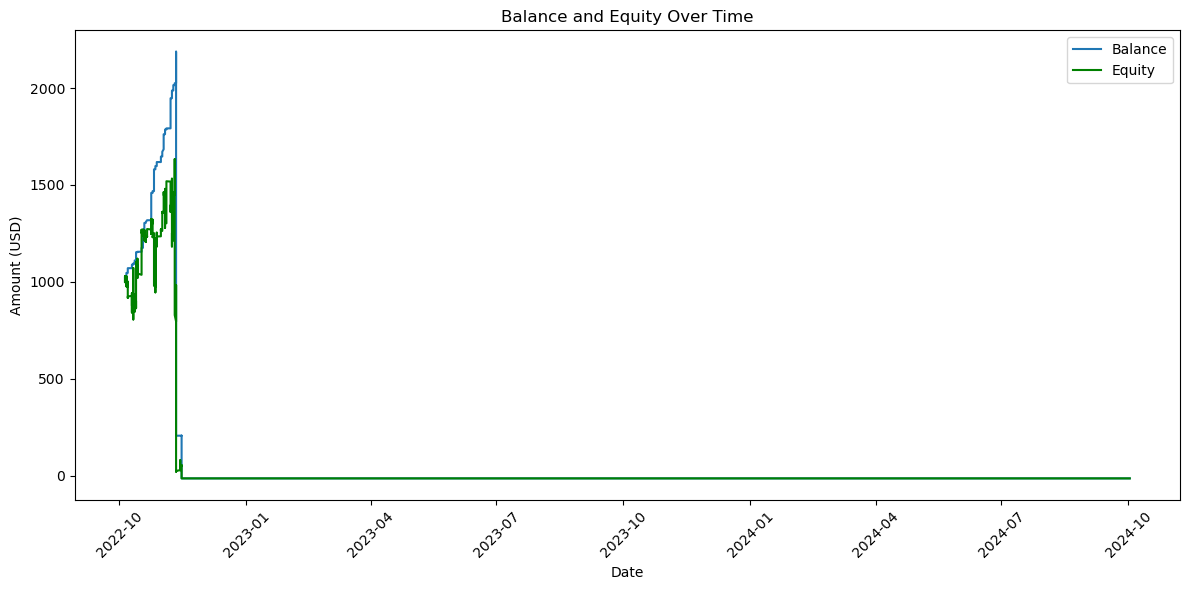

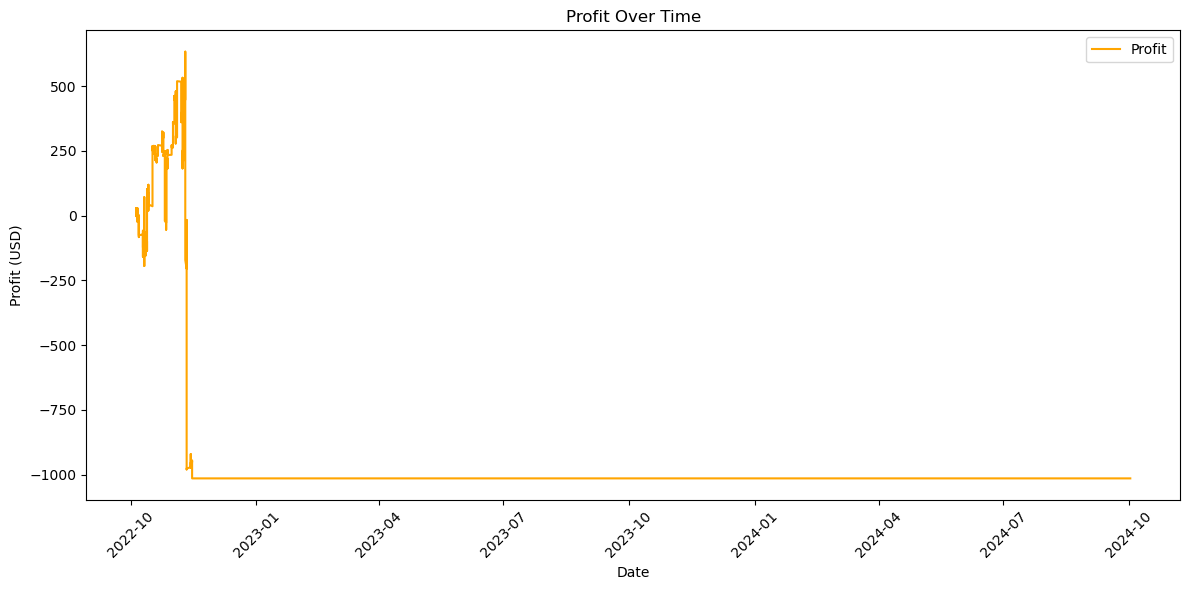

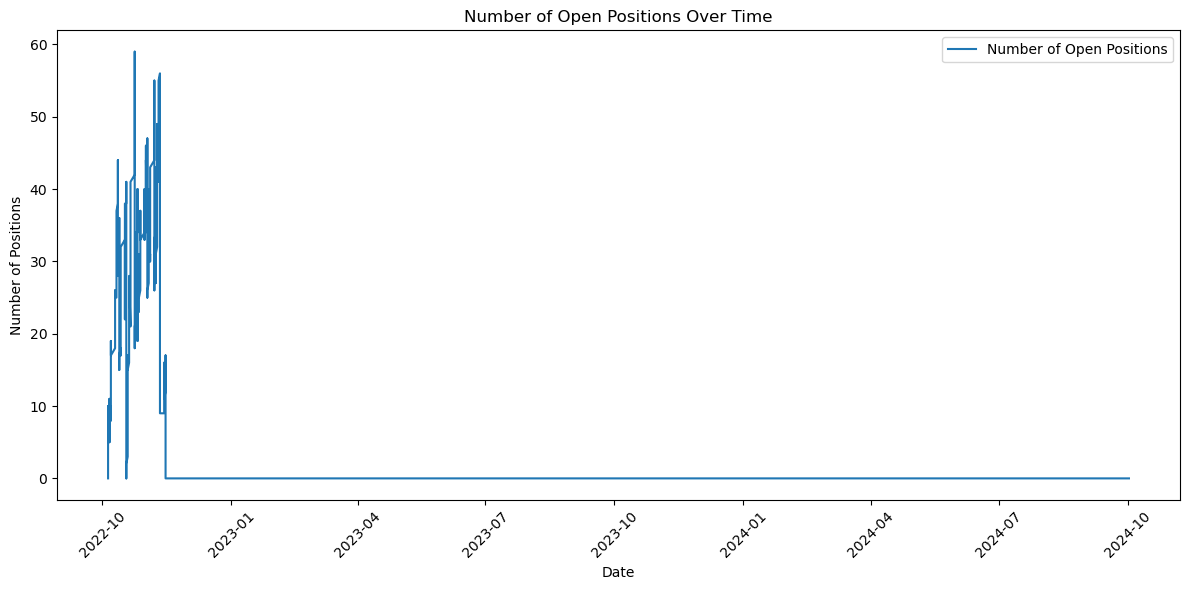

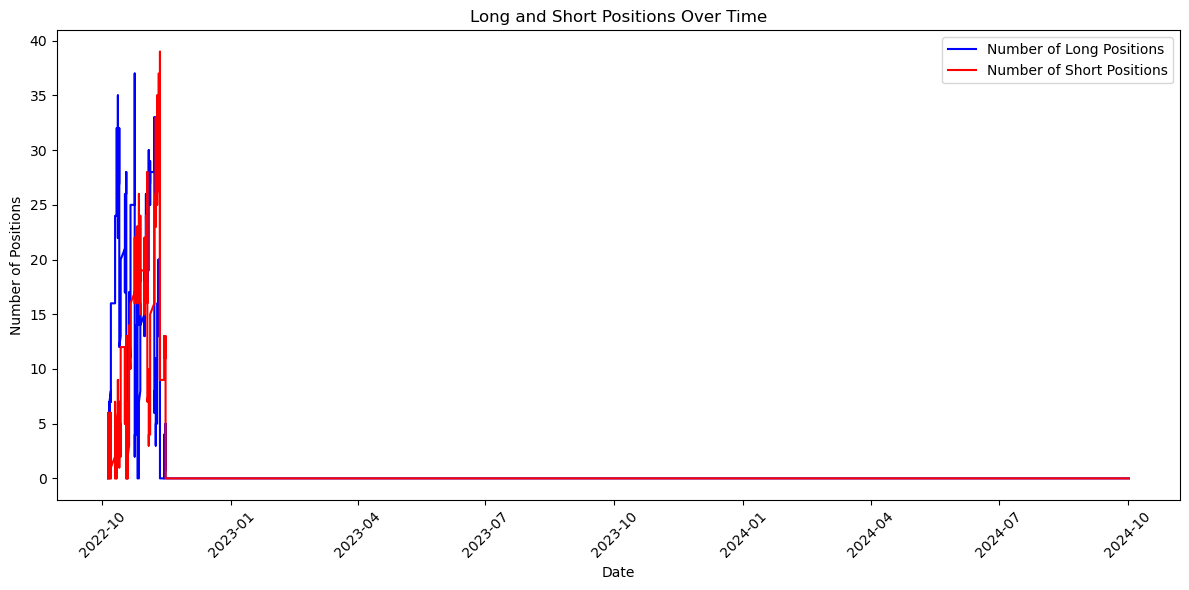

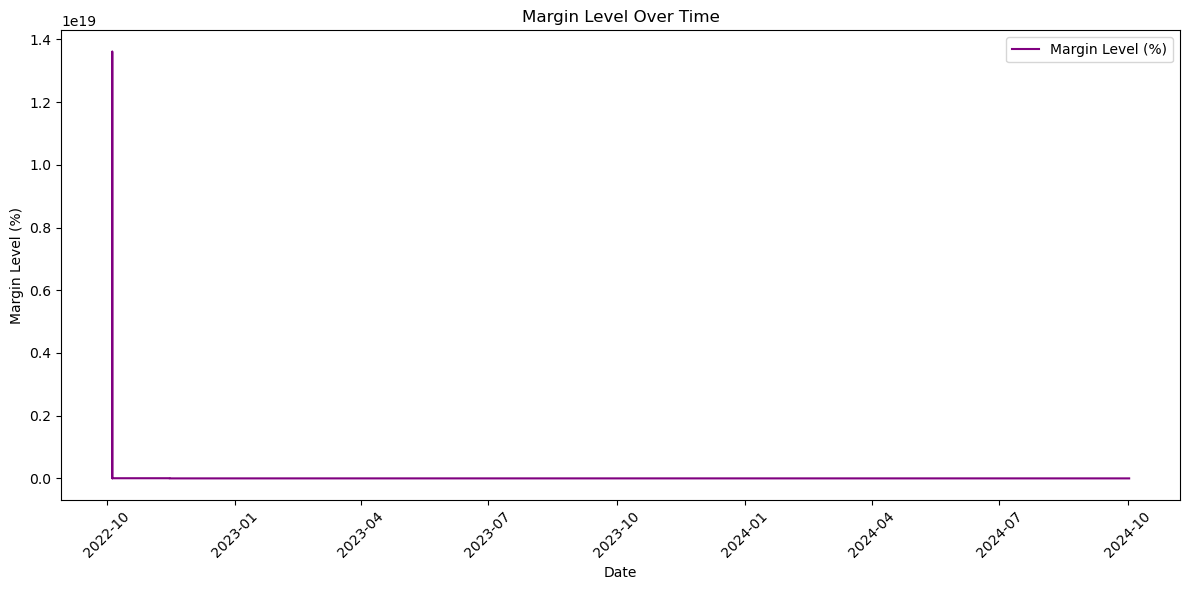

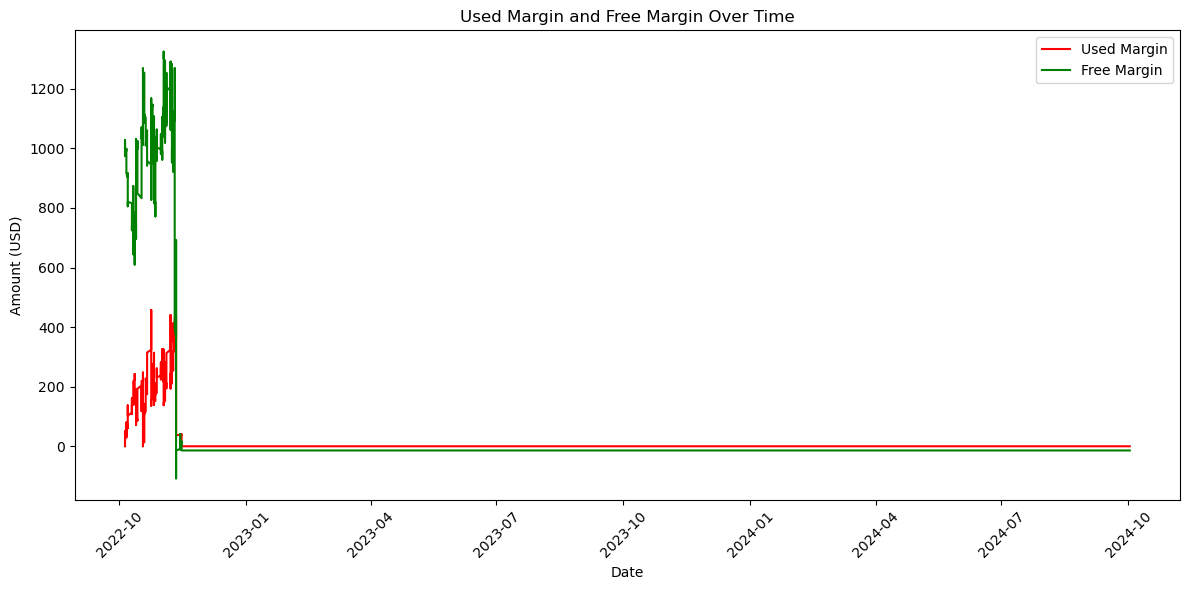

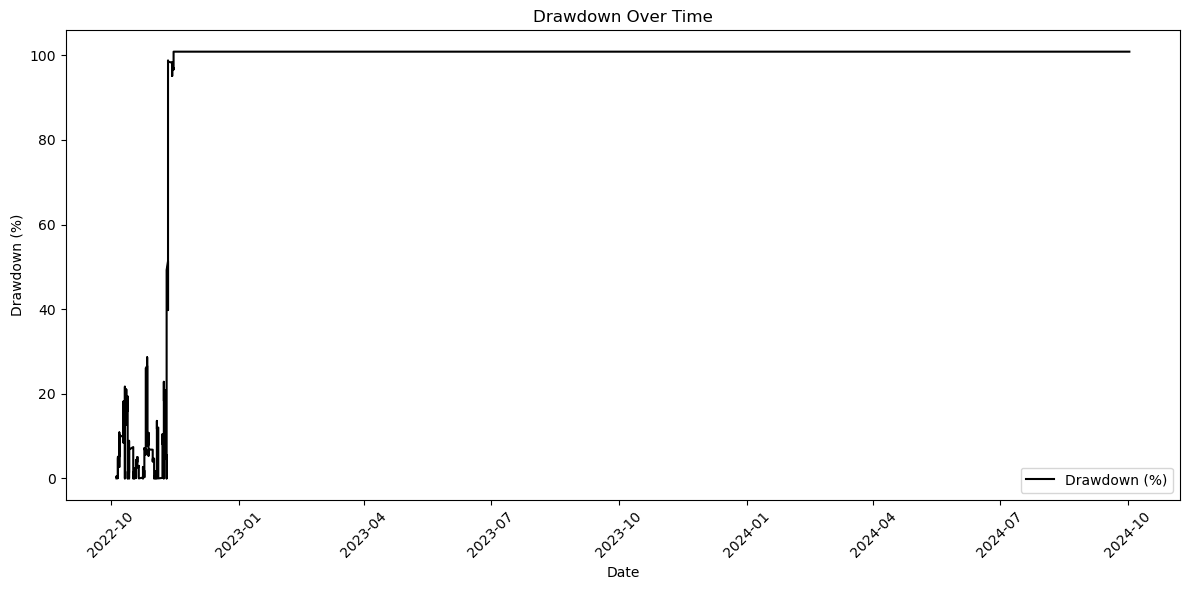

In [19]:
# ================================ 
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================

# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\RL_Forex_Trading_EA\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos', 'DateTime'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================

# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================

# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# ================================
# 5. SCALING AND NORMALIZING FEATURES
# ================================

# Before scaling, save unscaled prices for profit calculations
df['Unscaled_Open'] = df['Open']
df['Unscaled_High'] = df['High']
df['Unscaled_Low'] = df['Low']
df['Unscaled_Close'] = df['Close']

# Exclude price columns from scaling
price_columns = ['Open', 'High', 'Low', 'Close', 'Unscaled_Open', 'Unscaled_High', 'Unscaled_Low', 'Unscaled_Close']

# Select numerical columns to scale (excluding price columns)
numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() if col not in price_columns]

# Initialize scaler
scaler = MinMaxScaler()

# Fit scaler on the data and transform
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# ================================
# 6. DEFINING THE CUSTOM TRADING ENVIRONMENT
# ====================================

class ForexTradingEnv(gym.Env):
    """
    A custom OpenAI Gym environment for Forex trading that allows multiple positions and enforces specific closing rules,
    with margin and leverage considerations.
    """
    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()

        self.long_positions_history = []
        self.short_positions_history = []

        self.df = df.reset_index(drop=True)  # Ensure the DataFrame index is sequential
        self.total_steps = len(self.df)

        # Initial account balance (Cent Account with $1,000 USD)
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.equity = self.initial_balance

        # Leverage and margin settings
        self.leverage = 200  # Leverage ratio
        self.margin_call_level = 100  # Margin Call Level (%)
        self.stop_out_level = 50  # Stop Out Level (%)

        # Margin variables
        self.used_margin = 0
        self.free_margin = self.balance - self.used_margin
        self.margin_level = np.inf  # Initially infinite when no positions are open

        # Positions will be stored in a list
        self.open_positions = []  # Each position is a dictionary with 'type', 'entry_price', and 'size'

        # For tracking history
        self.balance_history = []
        self.equity_history = []
        self.position_history = []
        self.used_margin_history = []
        self.free_margin_history = []
        self.margin_level_history = []

        # Exclude unscaled price columns from observation
        price_columns = ['Unscaled_Open', 'Unscaled_High', 'Unscaled_Low', 'Unscaled_Close']
        self.numeric_columns = [col for col in self.df.select_dtypes(include=[np.number]).columns.tolist() if col not in price_columns]

        # Define action and observation space
        # Action space mapping:
        # 0 - Hold
        # 1 - Buy 0.5x
        # 2 - Buy 1x
        # 3 - Buy 1.5x
        # 4 - Buy 2x
        # 5 - Sell 0.5x
        # 6 - Sell 1x
        # 7 - Sell 1.5x
        # 8 - Sell 2x
        # 9 - Attempt to Close Positions
        self.action_space = spaces.Discrete(10)

        # Observation space: all numerical features except unscaled prices, plus margin variables
        num_features = len(self.numeric_columns) + 3  # Additional margin variables
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

        # Initialize trade log
        self.trade_log = []

    def reset(self, *, seed=None, options=None):
        """
        Reset the state of the environment to an initial state.
        """
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.equity = self.initial_balance
        self.open_positions = []

        # Reset margin variables
        self.used_margin = 0
        self.free_margin = self.balance - self.used_margin
        self.margin_level = np.inf

        # Reset history
        self.balance_history = [self.balance]
        self.equity_history = [self.equity]
        self.position_history = [len(self.open_positions)]
        self.used_margin_history = [self.used_margin]
        self.free_margin_history = [self.free_margin]
        self.margin_level_history = [self.margin_level]

        # Initialize long and short positions history
        num_long_positions = sum(1 for pos in self.open_positions if pos['type'] == 'long')
        num_short_positions = sum(1 for pos in self.open_positions if pos['type'] == 'short')

        self.long_positions_history = [num_long_positions]
        self.short_positions_history = [num_short_positions]

        # Reset trade log
        self.trade_log = []

        return self._next_observation(), {}

    def _next_observation(self):
        """
        Get the observation for the current step.
        """
        # Extract the current row
        obs = self.df.loc[self.current_step, self.numeric_columns].values.astype(np.float32)

        # Replace any NaNs with zeros to ensure stability
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)

        # Add margin variables to observation
        # Handle infinite margin_level by capping it to a large finite value
        capped_margin_level = self.margin_level if np.isfinite(self.margin_level) else 1e6
        additional_obs = np.array([
            self.used_margin / self.initial_balance,
            self.free_margin / self.initial_balance,
            capped_margin_level / 1000  # To normalize
        ], dtype=np.float32)

        # Ensure no NaNs or Infs in additional_obs
        additional_obs = np.nan_to_num(additional_obs, nan=0.0, posinf=1e6 / 1000, neginf=0.0)

        # Concatenate the margin information to the observation
        obs = np.concatenate((obs, additional_obs))

        # Final check for NaNs in the observation
        if np.any(np.isnan(obs)):
            print(f"NaN detected in observation at step {self.current_step}")
            obs = np.nan_to_num(obs, nan=0.0, posinf=1e6 / 1000, neginf=0.0)

        return obs

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        terminated = False
        truncated = False

        # Use unscaled close price for profit calculations
        current_price = self.df.loc[self.current_step, 'Unscaled_Close']
        total_realized_profit = 0

        # Initialize penalty for invalid actions
        penalty = 0

        # Define action mappings
        action_mappings = {
            0: {'type': 'hold', 'multiplier': 0},
            1: {'type': 'buy', 'multiplier': 0.5},
            2: {'type': 'buy', 'multiplier': 1},
            3: {'type': 'buy', 'multiplier': 1.5},
            4: {'type': 'buy', 'multiplier': 2},
            5: {'type': 'sell', 'multiplier': 0.5},
            6: {'type': 'sell', 'multiplier': 1},
            7: {'type': 'sell', 'multiplier': 1.5},
            8: {'type': 'sell', 'multiplier': 2},
            9: {'type': 'close', 'multiplier': 0}
        }

        # **Fixing the TypeError by ensuring 'action' is a scalar integer**
        if isinstance(action, np.ndarray):
            action = int(action.item())  # Convert single-element array to int
        else:
            action = int(action)

        action_info = action_mappings.get(action)
        if action_info is None:
            penalty -= 10  # Invalid action
        else:
            action_type = action_info['type']
            multiplier = action_info['multiplier']

            if action_type == 'hold':
                # Do nothing
                pass
            elif action_type in ['buy', 'sell']:
                # Open Long or Short Position with specified multiplier
                if len(self.open_positions) < 400:  # Limit the number of open positions
                    risk_percentage = 1
                    base_position_size = self.equity * risk_percentage
                    self.position_size = base_position_size * multiplier

                    required_margin = self.position_size / self.leverage
                    if self.free_margin >= required_margin and self.position_size > 0:
                        position = {
                            'type': 'long' if action_type == 'buy' else 'short',
                            'entry_price': current_price,
                            'size': self.position_size
                        }
                        # Proceed to open position
                        self.open_positions.append(position)
                        # Update margins
                        self.used_margin += required_margin
                        self.free_margin -= required_margin
                        # Record the trade
                        trade = {
                            'step': self.current_step,
                            'date': self.df.loc[self.current_step, 'Date'],
                            'action': 'Buy' if action_type == 'buy' else 'Sell',
                            'position_size_lots': self.position_size / 100000,  # Convert units to lots
                            'entry_price': current_price
                        }
                        self.trade_log.append(trade)
                    else:
                        # Not enough free margin to open position or position size is zero
                        penalty -= 10  # Penalize the agent for invalid action
                else:
                    # Too many open positions
                    penalty -= 10  # Penalize the agent for invalid action

            elif action_type == 'close':
                # Attempt to Close Positions (same as before)
                profit_positions = []
                loss_positions = []
                positions_to_close = []

                # Separate positions into profitable and losing
                for pos in self.open_positions:
                    if pos['type'] == 'long':
                        pnl = (current_price - pos['entry_price']) * pos['size']
                    else:  # 'short'
                        pnl = (pos['entry_price'] - current_price) * pos['size']

                    if pnl > 0:
                        profit_positions.append({'position': pos, 'pnl': pnl})
                    else:
                        loss_positions.append({'position': pos, 'pnl': pnl})

                # Total profit from profitable positions
                profit_from_profitable_positions = sum([p['pnl'] for p in profit_positions])

                if profit_from_profitable_positions > 0:
                    # Close profitable positions
                    for p in profit_positions:
                        # Update balance
                        self.balance += p['pnl'] * 0.5  # Half of profit goes to balance
                        total_realized_profit += p['pnl']
                        # Release margin
                        required_margin = p['position']['size'] / self.leverage
                        self.used_margin -= required_margin
                        self.free_margin += required_margin
                        positions_to_close.append(p['position'])
                        # Record the trade
                        trade = {
                            'step': self.current_step,
                            'date': self.df.loc[self.current_step, 'Date'],
                            'action': 'Close',
                            'position_type': 'Buy' if p['position']['type'] == 'long' else 'Sell',
                            'position_size_lots': p['position']['size'] / 100000,
                            'entry_price': p['position']['entry_price'],
                            'exit_price': current_price,
                            'profit_loss': p['pnl']
                        }
                        self.trade_log.append(trade)

                    # Use half of profit to close losses
                    available_for_losses = profit_from_profitable_positions * 0.5

                    # Sort loss positions by PnL ascending (smallest losses first)
                    loss_positions.sort(key=lambda x: x['pnl'])

                    for l in loss_positions:
                        required_amount = -l['pnl']
                        if available_for_losses >= required_amount:
                            # Can fully close this losing position
                            total_realized_profit += l['pnl']  # Negative value
                            # Release margin
                            required_margin = l['position']['size'] / self.leverage
                            self.used_margin -= required_margin
                            self.free_margin += required_margin
                            positions_to_close.append(l['position'])
                            available_for_losses -= required_amount
                            # Record the trade
                            trade = {
                                'step': self.current_step,
                                'date': self.df.loc[self.current_step, 'Date'],
                                'action': 'Close',
                                'position_type': 'Buy' if l['position']['type'] == 'long' else 'Sell',
                                'position_size_lots': l['position']['size'] / 100000,
                                'entry_price': l['position']['entry_price'],
                                'exit_price': current_price,
                                'profit_loss': l['pnl']
                            }
                            self.trade_log.append(trade)
                        else:
                            # Partially close the losing position
                            partial_size = (available_for_losses / required_amount) * l['position']['size']
                            partial_pnl = l['pnl'] * (partial_size / l['position']['size'])
                            # Adjust the position size accordingly
                            l['position']['size'] -= partial_size
                            total_realized_profit += partial_pnl  # Negative value
                            # Release margin for the partial size
                            required_margin = partial_size / self.leverage
                            self.used_margin -= required_margin
                            self.free_margin += required_margin
                            # Record the trade
                            trade = {
                                'step': self.current_step,
                                'date': self.df.loc[self.current_step, 'Date'],
                                'action': 'Partial Close',
                                'position_type': 'Buy' if l['position']['type'] == 'long' else 'Sell',
                                'position_size_lots': partial_size / 100000,
                                'entry_price': l['position']['entry_price'],
                                'exit_price': current_price,
                                'profit_loss': partial_pnl
                            }
                            self.trade_log.append(trade)
                            available_for_losses = 0
                            break  # No more funds to close additional losses

                    # Remove closed positions from open_positions
                    for pos in positions_to_close:
                        if pos in self.open_positions:
                            self.open_positions.remove(pos)

        # Calculate unrealized PnL
        unrealized_pnl = 0
        for pos in self.open_positions:
            if pos['type'] == 'long':
                pnl = (current_price - pos['entry_price']) * pos['size']
            else:  # 'short'
                pnl = (pos['entry_price'] - current_price) * pos['size']
            unrealized_pnl += pnl

        # Update equity
        self.equity = self.balance + unrealized_pnl

        # Update free margin
        self.free_margin = self.equity - self.used_margin

        # Update margin level, ensuring no division by zero
        if self.used_margin > 0:
            self.margin_level = (self.equity / self.used_margin) * 100
        else:
            self.margin_level = 1e6  # Assign a large finite value instead of infinity

        # Check for margin call / stop out
        if self.margin_level <= self.stop_out_level:
            # Close positions until margin level is above stop out level
            positions_to_close = []
            # Sort positions by PnL ascending (largest losses first)
            positions_with_pnl = []
            for pos in self.open_positions:
                if pos['type'] == 'long':
                    pnl = (current_price - pos['entry_price']) * pos['size']
                else:  # 'short'
                    pnl = (pos['entry_price'] - current_price) * pos['size']
                positions_with_pnl.append({'position': pos, 'pnl': pnl})

            positions_with_pnl.sort(key=lambda x: x['pnl'])

            for p in positions_with_pnl:
                # Close position
                if p['pnl'] >= 0:
                    self.balance += p['pnl']
                else:
                    self.balance += p['pnl']  # Negative value
                total_realized_profit += p['pnl']

                # Release margin
                required_margin = p['position']['size'] / self.leverage
                self.used_margin -= required_margin
                self.free_margin += required_margin

                positions_to_close.append(p['position'])
                # Record the trade
                trade = {
                    'step': self.current_step,
                    'date': self.df.loc[self.current_step, 'Date'],
                    'action': 'Margin Call Close',
                    'position_type': 'Buy' if p['position']['type'] == 'long' else 'Sell',
                    'position_size_lots': p['position']['size'] / 100000,
                    'entry_price': p['position']['entry_price'],
                    'exit_price': current_price,
                    'profit_loss': p['pnl']
                }
                self.trade_log.append(trade)

                # Recalculate equity and margin level
                unrealized_pnl -= p['pnl']  # Subtract the PnL of the closed position
                self.equity = self.balance + unrealized_pnl

                if self.used_margin > 0:
                    self.margin_level = (self.equity / self.used_margin) * 100
                else:
                    self.margin_level = 1e6  # Assign a large finite value instead of infinity

                if self.margin_level > self.stop_out_level:
                    break  # Margin level is acceptable

            # Remove closed positions from open_positions
            for pos in positions_to_close:
                if pos in self.open_positions:
                    self.open_positions.remove(pos)

        # Append history
        self.balance_history.append(self.balance)
        self.equity_history.append(self.equity)
        self.position_history.append(len(self.open_positions))
        self.used_margin_history.append(self.used_margin)
        self.free_margin_history.append(self.free_margin)
        self.margin_level_history.append(self.margin_level)

        num_long_positions = sum(1 for pos in self.open_positions if pos['type'] == 'long')
        num_short_positions = sum(1 for pos in self.open_positions if pos['type'] == 'short')

        self.long_positions_history.append(num_long_positions)
        self.short_positions_history.append(num_short_positions)

        # Move to the next step
        self.current_step += 1

        # Check if the episode is over
        if self.current_step >= self.total_steps - 1:
            terminated = True

        observation = self._next_observation()

        # Calculate reward based on realized profit or loss
        reward = total_realized_profit + penalty  # Incorporate penalty for invalid actions

        # Introduce a drawdown penalty
        peak_equity = np.maximum.accumulate(np.array(self.equity_history))
        max_drawdown = np.max(peak_equity - np.array(self.equity_history))
        drawdown_penalty = max_drawdown * 0.2  # Adjust the multiplier as needed
        reward -= drawdown_penalty   

        # Final checks to prevent NaNs
        if not np.isfinite(self.equity):
            print(f"Non-finite equity detected at step {self.current_step}")
            self.equity = self.balance  # Reset equity to balance

        if not np.isfinite(reward):
            print(f"Non-finite reward detected at step {self.current_step}")
            reward = -1  # Assign a penalty

        return observation, reward, terminated, truncated, {}

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# Create the environment
env = ForexTradingEnv(df)

# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=20000)

# Save the trained model
model.save("PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================

# Load the trained PPO model
model = PPO.load("PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, _ = env.reset()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:
    # Get the action from your trained model
    action, _ = model.predict(state)
    
    # Step the environment with the chosen action
    state, reward, done, truncated, _ = env.step(action)

# ========================================
# 9. DISPLAYING THE TRADE LOG AFTER EVALUATION
# ========================================

# Ensure all rows and columns are displayed without truncation
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width based on the content
pd.set_option('display.colheader_justify', 'left')  # Justify column headers to the left
pd.set_option('display.float_format', '{:.5f}'.format)  # Limit float precision to 5 decimal places

# Convert trade log to DataFrame
trade_log_df = pd.DataFrame(env.trade_log)

# Display the trade log
print(trade_log_df)

# ========================================
# 10. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# Ensure 'Date' is a column in the DataFrame for plotting
if 'Date' not in env.df.columns:
    env.df.reset_index(inplace=True)

# Adjust dates to match the length of balance_history
dates = env.df['Date'].iloc[:len(env.balance_history)].reset_index(drop=True)

# 1. Plot Balance and Equity Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.balance_history, label="Balance")
plt.plot(dates, env.equity_history, label="Equity", color='green')
plt.title("Balance and Equity Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Plot Profit Over Time
plt.figure(figsize=(12, 6))
profit_history = np.array(env.equity_history) - env.initial_balance
plt.plot(dates, profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Date")
plt.ylabel("Profit (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot Number of Open Positions Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.position_history, label="Number of Open Positions")
plt.title("Number of Open Positions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Positions")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Plot Long and Short Positions Over Time
if hasattr(env, 'long_positions_history') and hasattr(env, 'short_positions_history'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, env.long_positions_history, label="Number of Long Positions", color='blue')
    plt.plot(dates, env.short_positions_history, label="Number of Short Positions", color='red')
    plt.title("Long and Short Positions Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Positions")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Plot Margin Level Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.margin_level_history, label="Margin Level (%)", color='purple')
plt.title("Margin Level Over Time")
plt.xlabel("Date")
plt.ylabel("Margin Level (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot Used Margin and Free Margin Over Time
plt.figure(figsize=(12, 6))
plt.plot(dates, env.used_margin_history, label="Used Margin", color='red')
plt.plot(dates, env.free_margin_history, label="Free Margin", color='green')
plt.title("Used Margin and Free Margin Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Plot Drawdown Over Time
plt.figure(figsize=(12, 6))
equity_array = np.array(env.equity_history)
peak_equity = np.maximum.accumulate(equity_array)
drawdown = (peak_equity - equity_array) / peak_equity * 100
plt.plot(dates, drawdown, label="Drawdown (%)", color='black')
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()